In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from my_functions import *

In [4]:
houses_train_cleaned = pd.read_csv('../datasets/cleaned/house_train_cleaned.csv')
houses_test_cleaned = pd.read_csv('../datasets/cleaned/house_test_cleaned.csv')

In [5]:
features = get_features(houses_train_cleaned, 0)
len(features)

224

In [6]:
X_real_test = houses_test_cleaned[[col for col in features if col in houses_test_cleaned]]
X_real_test.shape

(878, 203)

## Prepping model for Kaggle Submission

In [7]:
# Garage Cars was type int64 in houses_test_cleaned, was type float in houses_train_cleaned_pol_scale
houses_test_cleaned['Garage Cars'] = houses_test_cleaned['Garage Cars'].apply(lambda x: float(x))

In [8]:
houses_test_cleaned.shape

(878, 252)

## Testing!!

### Selecting X and Y

In [9]:
outlier_indices = [1796, 125] # These indices were throwing off my model drastically
X = houses_train_cleaned[[col for col in features if col in houses_test_cleaned]].drop(outlier_indices)
y = houses_train_cleaned['SalePrice'].drop(outlier_indices)

In [10]:
# Establishing OLS model to be able to select P-Values
model = sm.OLS(y, X).fit()

In [11]:
# Getting features under a certain pvalue, for this, I wanted to overfit my model
significant_features = list(model.pvalues[model.pvalues < 0.60].index) # Thanks foxyblue from Stack Overflow! https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas/41212509

In [12]:
X = houses_train_cleaned[[col for col in significant_features if col in houses_test_cleaned]].drop(outlier_indices)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=342)

In [14]:
# Scaling my data for Ridge
sc = StandardScaler()

In [15]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Training model on all data

In [16]:
lr = LinearRegression()

In [17]:
lr.fit(X, y)

LinearRegression()

In [18]:
X_real_test = houses_test_cleaned[[col for col in significant_features if col in houses_test_cleaned]]
X_real_test.shape

(878, 156)

In [19]:
X_real_test_sc = sc.fit_transform(X_real_test)

In [20]:
len(X_real_test)

878

In [21]:
# From Lesson 4.02 on Logistic Regression! Thanks Adi Brohnstein

r_alphas = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV( 
    alphas=r_alphas,
    scoring='r2',
    cv=5
)

# Fit model using best ridge alpha!
ridge_cv.fit(X_train_sc, y_train);

In [33]:
ridge_cv.score(X_test_sc, y_test)

0.9262476566583553

In [35]:
y_pred = ridge_cv.predict(X_test_sc)

In [36]:
print(f'The RMSE is {metrics.mean_squared_error(y_test, y_pred, squared=False)}')

The RMSE is 21683.368279409937


In [36]:
# Baseline Model
null_pred = np.zeros_like(y_test)
null_pred = null_pred + y_test.mean()
print(f'The Baseline RMSE is {metrics.mean_squared_error(y_test, null_pred, squared=False)}')

The Baseline RMSE is 79843.36540784538


## The Model is drastically outperforming the Baseline!

In [38]:
resids = y_test - y_pred

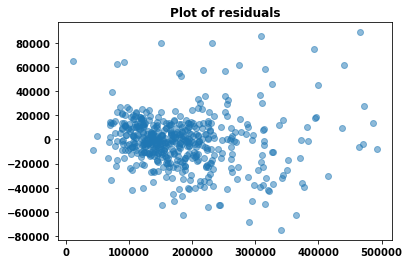

In [39]:
plt.scatter(y_pred, resids, alpha=0.5)
plt.title('Plot of residuals');

In [28]:
houses_test_cleaned['SalePrice'] = ridge_cv.predict(X_real_test_sc)

submission = houses_test_cleaned[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,181538.850717
std,850.838263,75923.842735
min,2.000000,27110.872549
25%,692.250000,129421.978218
50%,1433.000000,165508.422461
75%,2197.500000,216746.686997
max,2928.000000,611206.521194


In [27]:
submission.to_csv('../submissions/test47.csv', index=False)